# NK Problem Solver Perception-Action Cycle with Generalized FE

In [32]:
using Pkg
#Pkg.update("RxInfer")
Pkg.activate("..")
Pkg.instantiate()

#using Pkg
#Pkg.add(["RxInfer", "LinearAlgebra", "Plots", "Distributions"])
#Pkg.resolve();
#using Pkg
#Pkg.add("LaTeXStrings")
using RxInfer, LinearAlgebra, Plots, Distributions, LaTeXStrings, Random

  Activating project at `c:\Users\andre\.cursor-tutor-2\LAIF`


## Utility Functions

In [33]:
using DomainSets: Domain
using StatsFuns: gammainvcdf, loggamma
using ReactiveMP: AbstractContinuousGenericLogPdf, GenericLogPdfVectorisedProduct, UnspecifiedDomain, approximate_prod_with_sample_list
using RxInfer: AutoProposal, SampleListFormConstraint
using Random

import Base: prod, rand, eltype, size
import Distributions: logpdf, mean
import Random: rand, rand!
import ReactiveMP: getdomain, getlogpdf
import RxInfer: __approximate


h(A) = -diag(A'*safelog.(A))

mean_h(d::PointMass) = (d.point, h(d.point))

# ContinuousMatrixvariateLogPdf
struct ContinuousMatrixvariateLogPdf{D <: Domain, F} <: AbstractContinuousGenericLogPdf
    domain::D
    logpdf::F
end

ContinuousMatrixvariateLogPdf(f::Function) = ContinuousMatrixvariateLogPdf(UnspecifiedDomain(), f)

getdomain(d::ContinuousMatrixvariateLogPdf) = d.domain
getlogpdf(d::ContinuousMatrixvariateLogPdf) = d.logpdf


# SampleList
function __approximate(constraint::SampleListFormConstraint{N, R, S, M}, left::ContinuousMatrixvariateLogPdf, right) where {N, R, S <: AutoProposal, M}
    return approximate_prod_with_sample_list(constraint.rng, constraint.method, right, left, N)
end

function __approximate(constraint::SampleListFormConstraint{N, R, S, M}, left, right::ContinuousMatrixvariateLogPdf) where {N, R, S <: AutoProposal, M}
    return approximate_prod_with_sample_list(constraint.rng, constraint.method, left, right, N)
end

function __approximate(constraint::SampleListFormConstraint{N, R, S, M}, left::GenericLogPdfVectorisedProduct, right) where {N, R, S <: AutoProposal, M}
    return approximate_prod_with_sample_list(constraint.rng, constraint.method, right, left, N)
end

function __approximate(constraint::SampleListFormConstraint{N, R, S, M}, left, right::GenericLogPdfVectorisedProduct) where {N, R, S <: AutoProposal, M}
    return approximate_prod_with_sample_list(constraint.rng, constraint.method, left, right, N)
end

# These are hacks to make _rand! work with matrix variate logpfds
eltype(::GenericLogPdfVectorisedProduct) = Float64
eltype(::ContinuousMatrixvariateLogPdf) = Float64

function mean_h(d::SampleList)
    s = get_samples(d)
    w = get_weights(d)

    return (sum(s.*w), sum(h.(s).*w))
end


# MatrixDirichlet
size(d::MatrixDirichlet) = size(d.a)

function logpdf(d::MatrixDirichlet, x::AbstractMatrix)
    return sum(sum((d.a.-1).*log.(x),dims=1) - sum(loggamma.(d.a), dims=1) + loggamma.(sum(d.a,dims=1)))
end
# Average energy definition for SampleList marginal
@average_energy MatrixDirichlet (q_out::SampleList, q_a::PointMass) = begin
    H = mapreduce(+, zip(eachcol(mean(q_a)), eachcol(mean(log, q_out)))) do (q_a_column, logmean_q_out_column)
        return -loggamma(sum(q_a_column)) + sum(loggamma.(q_a_column)) - sum((q_a_column .- 1.0) .* logmean_q_out_column)
    end
    return H
end
# In-place operations for sampling
function rand!(rng::AbstractRNG, d::MatrixDirichlet, container::Array{Float64, 3})
    s = size(d)
    for i in 1:size(container, 3)
        M = view(container, :, :, i)
        sample = rand(rng, d)
        copyto!(M, sample)
    end
    return container
end
# Custom sampling implementation
function rand(rng::AbstractRNG, d::MatrixDirichlet)
    U = rand(rng, size(d.a)...)
    S = gammainvcdf.(d.a, 1.0, U)
    return S./sum(S, dims=1) # Normalize columns
end

function mean_h(d::MatrixDirichlet)
    n_samples = 20 # Fixed number of samples
    s = [rand(d) for i=1:n_samples]

    return (sum(s)./n_samples, sum(h.(s))./n_samples)
end

# Transition
@rule Transition(:out, Marginalisation) (q_in::PointMass, q_a::Any) = begin
    a = clamp.(exp.(mean(log, q_a) * probvec(q_in)), tiny, Inf)
    return Categorical(a ./ sum(a))
end

@rule Transition(:a, Marginalisation) (q_out::Any, q_in::PointMass) = begin
    return MatrixDirichlet(collect(probvec(q_out)) * probvec(q_in)' .+ 1)
end


## goal_observation.jl & update rules

In [34]:
# goal_observation.jl content
using ForwardDiff: jacobian
using TupleTools: deleteat
using ReactiveMP: AbstractNodeFunctionalDependenciesPipeline, RequireMarginalFunctionalDependencies, messagein, setmessage!, get_samples, get_weights
import ReactiveMP: message_dependencies, marginal_dependencies

#include("distributions.jl")
struct GoalObservation end
@node GoalObservation Stochastic [c, z, A]
#----------
# Modifiers
#----------

# Metas
struct BetheMeta{P} # Meta parameterized by x type for rule overloading
    x::P # Pointmass value for observation
end
BetheMeta() = BetheMeta(missing) # Absent observation

struct GeneralizedMeta{P}
    x::P # Pointmass value for observation
    newton_iterations::Int64
end
GeneralizedMeta() = GeneralizedMeta(missing, 20)
GeneralizedMeta(point) = GeneralizedMeta(point, 20)

# Pipelines
struct BethePipeline <: AbstractNodeFunctionalDependenciesPipeline end
struct GeneralizedPipeline <: AbstractNodeFunctionalDependenciesPipeline
    init_message::Union{Bernoulli, Categorical}

    GeneralizedPipeline() = new() # If state is clamped, then no inital message is required
    GeneralizedPipeline(init_message::Union{Bernoulli, Categorical}) = new(init_message)
end

function message_dependencies(::BethePipeline, nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    return ()
end

# Bethe update rules for goal-observation node require marginals on all edges
function marginal_dependencies(::BethePipeline, nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    return nodelocalmarginals
end

# Generalized update rule for state requires inbound message
function message_dependencies(pipeline::GeneralizedPipeline, nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    if iindex === 2 && isdefined(pipeline, :init_message) # Message towards state
        input = ReactiveMP.messagein(nodeinterfaces[iindex])
        ReactiveMP.setmessage!(input, pipeline.init_message) # Predefine breaker message
        return (nodeinterfaces[iindex],) # Include inbound message on state
    else
        return ()
    end
end

# Generalized update rule for state requires inbound marginal
function marginal_dependencies(::GeneralizedPipeline, nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    if (iindex === 2) || (iindex === 3) # Message towards state or parameter
        return nodelocalmarginals # Include all marginals
    else
        return deleteat(nodelocalmarginals, cindex) # Include default marginals
    end
end


#------------------------------
# Unobserved Bethe Update Rules
#------------------------------

@rule GoalObservation(:c, Marginalisation) (q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::BetheMeta{Missing}) = begin
    log_c = mean(log, q_c)
    z = probvec(q_z)
    log_A = mean(log, q_A)

    # Compute internal marginal
    x = softmax(log_A*z + log_c)

    return Dirichlet(x .+ 1)
end

@rule GoalObservation(:z, Marginalisation) (q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::BetheMeta{Missing}) = begin
    log_c = mean(log, q_c)
    z = probvec(q_z)
    log_A = mean(log, q_A)

    # Compute internal marginal
    x = softmax(log_A*z + log_c)

    return Categorical(softmax(log_A'*x))
end

@rule GoalObservation(:A, Marginalisation) (q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::BetheMeta{Missing}) = begin
    log_c = mean(log, q_c)
    z = probvec(q_z)
    log_A = mean(log, q_A)

    # Compute internal marginal
    x = softmax(log_A*z + log_c)

    return MatrixDirichlet(x*z' .+ 1)
end

@average_energy GoalObservation (q_c::Union{Dirichlet, PointMass}, 
                                 q_z::Union{Bernoulli, Categorical, PointMass}, 
                                 q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                 meta::BetheMeta{Missing}) = begin
    log_c = mean(log, q_c)
    z = probvec(q_z)
    log_A = mean(log, q_A)

    # Compute internal marginal
    x = softmax(log_A*z + log_c)

    return -x'*(log_A*z + log_c - safelog.(x))
end


#----------------------------
# Observed Bethe Update Rules
#----------------------------

@rule GoalObservation(:c, Marginalisation) (q_c::Union{Dirichlet, PointMass}, # Unused
                                            q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::BetheMeta{<:AbstractVector}) = begin
    return Dirichlet(meta.x .+ 1)
end

@rule GoalObservation(:z, Marginalisation) (q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical}, # Unused
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::BetheMeta{<:AbstractVector}) = begin
    log_A = mean(log, q_A)

    return Categorical(softmax(log_A'*meta.x))
end

@rule GoalObservation(:A, Marginalisation) (q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, # Unused
                                            meta::BetheMeta{<:AbstractVector}) = begin
    z = probvec(q_z)

    return MatrixDirichlet(meta.x*z' .+ 1)
end

@average_energy GoalObservation (q_c::Union{Dirichlet, PointMass}, 
                                 q_z::Union{Bernoulli, Categorical, PointMass}, 
                                 q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                 meta::BetheMeta{<:AbstractVector}) = begin
    log_c = mean(log, q_c)
    z = probvec(q_z)
    log_A = mean(log, q_A)

    return -meta.x'*(log_A*z + log_c)
end


#------------------------------------
# Unobserved Generalized Update Rules
#------------------------------------

@rule GoalObservation(:c, Marginalisation) (q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::GeneralizedMeta{Missing}) = begin
    z = probvec(q_z)
    A = mean(q_A)

    return Dirichlet(A*z .+ 1)
end

@rule GoalObservation(:z, Marginalisation) (m_z::Union{Bernoulli, Categorical},
                                            q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical},
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::GeneralizedMeta{Missing}) = begin
    d = probvec(m_z)
    log_c = mean(log, q_c)
    z_0 = probvec(q_z)
    (A, h_A) = mean_h(q_A)

    # Root-finding problem for marginal statistics
    g(z) = z - softmax(-h_A + A'*log_c - A'*safelog.(A*z) + safelog.(d))

    z_k = deepcopy(z_0)
    for k=1:meta.newton_iterations
        z_k = z_k - inv(jacobian(g, z_k))*g(z_k) # Newton step for multivariate root finding
    end

    # Compute outbound message statistics
    rho = softmax(safelog.(z_k) - log.(d .+ 1e-6))

    return Categorical(rho)
end

@rule GoalObservation(:A, Marginalisation) (q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass},
                                            meta::GeneralizedMeta{Missing}) = begin
    log_c = mean(log, q_c)
    z = probvec(q_z)
    A_bar = mean(q_A)                                            

    log_mu(A) = (A*z)'*(log_c - safelog.(A_bar*z)) - z'*h(A)

    return ContinuousMatrixvariateLogPdf(log_mu)
end

@average_energy GoalObservation (q_c::Union{Dirichlet, PointMass}, 
                                 q_z::Union{Bernoulli, Categorical, PointMass}, 
                                 q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                 meta::GeneralizedMeta{Missing}) = begin
    log_c = mean(log, q_c)
    z = probvec(q_z)
    (A, h_A) = mean_h(q_A)

    return z'*h_A - (A*z)'*(log_c - safelog.(A*z))
end


#----------------------------------
# Observed Generalized Update Rules
#----------------------------------

@rule GoalObservation(:c, Marginalisation) (q_z::Union{Bernoulli, Categorical, PointMass}, # Unused
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, # Unused
                                            meta::GeneralizedMeta{<:AbstractVector}) = begin
    return Dirichlet(meta.x .+ 1)
end

@rule GoalObservation(:z, Marginalisation) (m_z::Union{Bernoulli, Categorical}, # Unused
                                            q_c::Union{Dirichlet, PointMass}, # Unused
                                            q_z::Union{Bernoulli, Categorical}, # Unused
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::GeneralizedMeta{<:AbstractVector}) = begin
    log_A = clamp.(mean(log, q_A), -12, 12)
    return Categorical(softmax(log_A'*meta.x))
end

@rule GoalObservation(:A, Marginalisation) (q_c::Union{Dirichlet, PointMass}, # Unused
                                            q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, # Unused
                                            meta::GeneralizedMeta{<:AbstractVector}) = begin
    z = probvec(q_z)

    return MatrixDirichlet(meta.x*z' .+ 1)
end

@average_energy GoalObservation (q_c::Union{Dirichlet, PointMass}, 
                                 q_z::Union{Bernoulli, Categorical, PointMass}, 
                                 q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                 meta::GeneralizedMeta{<:AbstractVector}) = begin
    log_c = mean(log, q_c)
    z = probvec(q_z)
    log_A = clamp.(mean(log, q_A), -12, 12)

    return -meta.x'*(log_A*z + log_c)
end

## helpers.jl / environment.jl / agent.jl

### constructABCD(α::Float64, c::Float64) - helpers.jl

In [35]:
function constructABCD(α::Float64, c::Float64)
    # Observation model
    A_1 = [0.5 0.5;
           0.5 0.5;
           0.0 0.0;
           0.0 0.0]
    A_2 = [0.0 0.0;
           0.0 0.0;
           α   1-α;
           1-α α  ]
    A_3 = [0.0 0.0;
           0.0 0.0;
           1-α α  ;
           α   1-α]
    A_4 = [1.0 0.0;
           0.0 1.0;
           0.0 0.0;
           0.0 0.0]
    A = zeros(16, 8)
    A[1:4, 1:2]   = A_1
    A[5:8, 3:4]   = A_2
    A[9:12, 5:6]  = A_3
    A[13:16, 7:8] = A_4
    # Transition model (with forced move back after reward-arm visit)
    B_1 = kron([1 1 1 1; # Row: can I move to 1?
                0 0 0 0;
                0 0 0 0;
                0 0 0 0], I(2))
    B_2 = kron([0 1 1 0; 
                1 0 0 1; # Row: can I move to 2?
                0 0 0 0;
                0 0 0 0], I(2))
    B_3 = kron([0 1 1 0;
                0 0 0 0;
                1 0 0 1; # Row: can I move to 3?
                0 0 0 0], I(2))
    B_4 = kron([0 1 1 0;
                0 0 0 0;
                0 0 0 0;
                1 0 0 1], I(2)) # Row: can I move to 4?
    B = [B_1, B_2, B_3, B_4]
    C = softmax(kron(ones(4), [0.0, 0.0, c, -c])) # Goal prior
    D = kron([1.0, 0.0, 0.0, 0.0], [0.5, 0.5]) # Initial state prior
    return (A, B, C, D)
end

constructABCD (generic function with 1 method)

### constructPriors()

In [36]:
function constructPriors()
    eps = 0.1
    # Position 1 surely does not offer disambiguation
    A_0_1 = [10.0 10.0;
             10.0 10.0;
             eps  eps;
             eps  eps]
    # But the other positions might
    A_0_X = [1.0  eps;
             eps  1.0;
             eps  eps;
             eps  eps]
    A_0 = eps*ones(16, 8) # Vague prior on everything else
    A_0[1:4, 1:2] = A_0_1
    A_0[5:8, 3:4] = A_0_X
    A_0[9:12, 5:6] = A_0_X
    A_0[13:16, 7:8] = A_0_X
    # Agent knows it starts at position 1
    D_0 = zeros(8)
    D_0[1:2] = [0.5, 0.5]

    return (A_0, D_0)
end

constructPriors (generic function with 1 method)

### generateGoalSequence(S::Int64)

In [37]:
function generateGoalSequence(S::Int64)
    rs = Vector{Vector}(undef, S)
    for si=1:S
        if rand() > 0.5
            rs[si] = [0, 1]
        else
            rs[si] = [1, 0]
        end
    end
    return rs
end

function generateGoalSequence(seed::Int64, S::Int64)
    Random.seed!(seed)
    generateGoalSequence(S)
end

generateGoalSequence (generic function with 2 methods)

### initializeWorld(A, B, C, D, rs)

In [38]:
function initializeWorld(A, B, C, D, rs)
    function reset(s)
       z_0 = zeros(8)
       z_0[1:2] = rs[s]
       z_t_min = z_0
       x_t = A*z_0
       return Int64(r'*[2, 3]) # Hidden reward position
    end
    r = [0, 1]     # Set reward position
    z_0 = zeros(8) # Initial state
    z_0[1:2] = r # Start from position 1
    # Execute a move to position a_t
    z_t_min = z_0
    function execute(a_t::Int64)
        z_t = B[a_t]*z_t_min # State transition
        x_t = A*z_t # Observation probabilities
        z_t_min = z_t # Reset state for next step
    end
    x_t = A*z_0
    function observe()
        s = rand(Categorical(x_t))
        o_t = zeros(16)
        o_t[s] = 1.0
        return o_t # One-hot observation
    end
    return (reset, execute, observe)
end

initializeWorld (generic function with 1 method)

### initializeAgent(A_0, B, C, D_0)

In [39]:
# agent.jl content
function initializeAgent(A_0, B, C, D_0)
    iterations = 50 # Iterations of variational algorithm
    A_s = deepcopy(A_0)
    D_s = deepcopy(D_0)
    function infer(t::Int64, a::Vector, o::Vector)
        # Define possible policies
        G = Matrix{Union{Float64, Missing}}(missing, 4, 4)
        if t === 1
            pols = [(1,1), (1,2), (1,3), (1,4), (2,1), (3,1), (4,1), (4,2), (4,3), (4,4)]
        elseif t === 2
            a1 = a[1] # Register first move
            if a1 in [2, 3]
                pols = [(a1,1)] # Mandatory move to 1
            else
                pols = [(a1,1), (a1,2), (a1,3), (a1,4)]
            end
        elseif t === 3
            a1 = a[1] # Register both moves
            a2 = a[2]
            pols = [(a1, a2)]
        end
    
        # Define (un)observed data for meta objects
        x = Vector{Union{Vector{Float64}, Missing}}(missing, 2)
        for k=1:2
            if isassigned(o, k) # Observed datapoint
                x[k] = o[k]
            end
        end
    
        # Define model
        model = t_maze(A_s, D_s, x)
    
        # Define constraints
        constraints = structured(t<3) # Sampling approximation for t<3
    
        for (i, j) in pols
            data = (u = [B[i], B[j]],
                    c = [C, C])
    
            initmarginals = (A   = MatrixDirichlet(asym(A_s)),
                             z_0 = Categorical(asym(8)),
                             z   = [Categorical(asym(8)),
                                    Categorical(asym(8))])
    
            res = inference(model         = model,
                            constraints   = constraints, 
                            data          = data,
                            initmarginals = initmarginals,
                            iterations    = iterations,
                            free_energy   = true)
            
            G[i, j] = mean(res.free_energy[10:iterations])./log(2) # Average to smooth fluctuations and convert to bits
            if t === 3 # Return posterior statistics after learning
                A_s = res.posteriors[:A][end].a
            end
        end
    
        return (G, A_s)
    end
    
    function act(t, G)
        # We include policy selection in the act function for clearer code; procedurally, policy selection belongs in the plan step
        idx = findall((!).(ismissing.(G))) # Find coordinates of non-missing entries
        Gvec = G[idx] # Convert to vector of valid entries
        p = softmax(-10.0*Gvec) # Sharpen for minimum selection
        pol = rand(Categorical(p)) # Select a policy
        
        return idx[pol][t] # Select current action from policy
    end

    return (infer, act)
end

initializeAgent (generic function with 1 method)

## visualizations.jl 

In [40]:
# visualizations.jl content
function extractWins(os)
    win_mask = kron(ones(Int64, 4), [0,0,1,0])
    wins = Vector{Float64}(undef, S)
    for s=1:S
        win_1 = win_mask'*os[s][1]
        win_2 = win_mask'*os[s][2]
        wins[s] = win_1 + win_2
    end

    return wins
end

function plotObservationStatistics(A::Matrix, A_0::Matrix; title="")
    # Inspect difference in observation statistics
    # dA = sparse(round.(A - A_0, digits=1))
    dA = Matrix{Union{Missing,Float64}}(A - A_0)
    zs = (dA .< 0.01)
    dA[zs] .= missing
    dA_1 = dA[1:4, 1:2]
    dA_2 = dA[5:8, 3:4]
    dA_3 = dA[9:12, 5:6]
    dA_4 = dA[13:16, 7:8]
    cmax = maximum(skipmissing(dA))

    yticks = ([1, 2, 3, 4], ["CL", "CR", "RW", "NR"])
    empty = ([1, 2, 3, 4], ["", "", "", ""])
    xticks = ([1, 2], ["RL", "RR"])
    cg = cgrad(:grays, rev = true)
    p1 = heatmap(dA_1, title=L"O", yflip=true, c=cg, colorbar=false, clim=(0, 55), color=:grays, xticks=xticks, yticks=yticks)
    p2 = heatmap(dA_2, title=L"L", yflip=true, c=cg, colorbar=false, clim=(0, 55), color=:grays, xticks=xticks, yticks=empty)
    p3 = heatmap(dA_3, title=L"R", yflip=true, c=cg, colorbar=false, clim=(0, 55), color=:grays, xticks=xticks, yticks=empty)
    p4 = heatmap(dA_4, title=L"C", yflip=true, c=cg, colorbar=false, clim=(0, 55), xticks=xticks, yticks=empty)

    for (px, dA_x) in [(p1,dA_1), (p2,dA_2), (p3,dA_3), (p4,dA_4)]
        for i=1:4
            for j=1:2
                ismissing(dA_x[i,j]) && continue

                # Annotate number
                if dA_x[i,j] <= 30
                    colour = :black
                else
                    colour = :white
                end
                
                ann = (j, i, text(round(dA_x[i,j], digits=1), 10, colour, :center))

                annotate!(px, ann, linecolor=colour)
            end
        end
    end

    plot(p1, p2, p3, p4, layout=grid(1,4,widths=[0.25,0.25,0.25,0.25]), size=(500,220), dpi=300, plot_title=title, plot_titlevspan=0.1)
end

function plotFreeEnergyMinimum(Gs, os; args...)
    S = length(Gs)
    # Plot free energies over simulations
    G1_mins = [minimum(skipmissing(Gs[s][1])) for s=1:S]
    G2_mins = [minimum(skipmissing(Gs[s][2])) for s=1:S]
    G3s = [minimum(skipmissing(Gs[s][3])) for s=1:S]
    empty_ticks = ([0,25,50,75,100],["","","","",""])
    p1 = plot(1:S, G1_mins, xticks=empty_ticks, ylabel="Free Energy Minimum [bits]", label="t=1", lw=2, linestyle=:dashdot; args...)
    plot!(p1, 1:S, G2_mins, label="t=2", lw=2, linestyle=:dash)
    plot!(p1, 1:S, G3s, label="t=3", lw=2)
    wins = extractWins(os)
    p2 = scatter(1:S, 1 .- wins, xlabel="Simulation Trial (s)", yticks=([0, 1], ["win", "loss"]), color=:black, legend=false, ylim=(-0.1, 1.1), markersize=2.5) # Plot non-reward
    plot(p1, p2, layout=grid(2,1,heights=[0.8,0.2]), dpi=300)
end

# helpers.jl
# Alias for safe logarithm
const safelog = ReactiveMP.clamplog
# Softmax that plays nice with automatic differentiation
function softmax(v::AbstractVector)
    r = clamp.(v .- maximum(v), -100, 0.0)
    exp.(r)./sum(exp.(r))
end
# Symmetry breaking for vague Categorical statistics
function asym(n::Int64)
    p = ones(n) .+ 1e-3*rand(n)
    return p./sum(p)
end
# Symmetry breaking for matrix Dirichlet statistics
asym(A::Matrix) = A + 1e-2*rand(size(A)...)

asym (generic function with 2 methods)

## Function testing cell

In [41]:
Atest, Btest, Ctest, Dtest = constructABCD(α, c)
println("Atest = $Atest")
println("with size $(size(Atest))")
println("Atest[1] = $(Atest[1])")
println("Atest[1:4, 1:2] = $(Atest[1:4, 1:2])")
A_4 = [1.0 0.0;
0.0 1.0;
0.0 0.0;
0.0 0.0]
println("A_4 = $A_4 with size $(size(A_4))")

Atest = [0.5 0.5 0.0 0.0 0.0 0.0 0.0 0.0; 0.5 0.5 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.9 0.09999999999999998 0.0 0.0 0.0 0.0; 0.0 0.0 0.09999999999999998 0.9 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.09999999999999998 0.9 0.0 0.0; 0.0 0.0 0.0 0.0 0.9 0.09999999999999998 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
with size (16, 8)
Atest[1] = 0.5
Atest[1:4, 1:2] = [0.5 0.5; 0.5 0.5; 0.0 0.0; 0.0 0.0]
A_4 = [1.0 0.0; 0.0 1.0; 0.0 0.0; 0.0 0.0] with size (4, 2)


## Agent

In [42]:
# Define the generative model
@model function t_maze(A_s, D_s, x)
    u = datavar(Matrix{Int64}, 2) # Policy for evaluations
    z = randomvar(2) # Latent states
    c = datavar(Vector{Float64}, 2) # Goal prior statistics

    z_0 ~ Categorical(D_s) # State prior
    A ~ MatrixDirichlet(A_s) # Observation matrix prior

    z_k_min = z_0
    for k=1:2
        z[k] ~ Transition(z_k_min, u[k])
        c[k] ~ GoalObservation(z[k], A) where {
            meta=GeneralizedMeta(x[k]), 
            pipeline=GeneralizedPipeline(vague(Categorical,8))} # With breaker message

        z_k_min = z[k] # Reset for next slice
    end
end

# Define constraints on the variational density
@constraints function structured(approximate::Bool)
    q(z_0, z, A) = q(z_0, z)q(A)
    if approximate # Sampling approximation on A required for t<3
        q(A) :: SampleList(20)
    end
end

structured (generic function with 1 method)

## Simulation

In [43]:
# Define experimental setting
α = 0.9; c = 2.0 # Reward probability and utility
S = 100 # Number of trials
seed = 666 # Randomizer seed

(A, B, C, D) = constructABCD(α, c)
(A_0, D_0) = constructPriors() # Construct prior statistics for A and D

rs = generateGoalSequence(seed, S) # Sets random seed and returns reproducible goal sequence
(reset, execute, observe) = initializeWorld(A, B, C, D, rs) # Let there be a world
(infer, act) = initializeAgent(A_0, B, C, D_0) # Let there be a constrained agent

# Step through the experimental protocol
As = Vector{Matrix}(undef, S) # Posterior statistics for A
Gs = [Vector{Matrix}(undef, 3) for s=1:S] # Free energy values per time
as = [Vector{Int64}(undef, 2) for s=1:S] # Actions per time
os = [Vector{Vector}(undef, 2) for s=1:S] # Observations (one-hot) per time
for s = 1:S
    reset(s) # Reset world
    for t=1:2
        (Gs[s][t], _) = infer(t, as[s], os[s])
             as[s][t] = act(t, Gs[s][t])
                        execute(as[s][t])
             os[s][t] = observe()
    end
    (Gs[s][3], As[s]) = infer(3, as[s], os[s]) # Learn at t=3
end

## Results

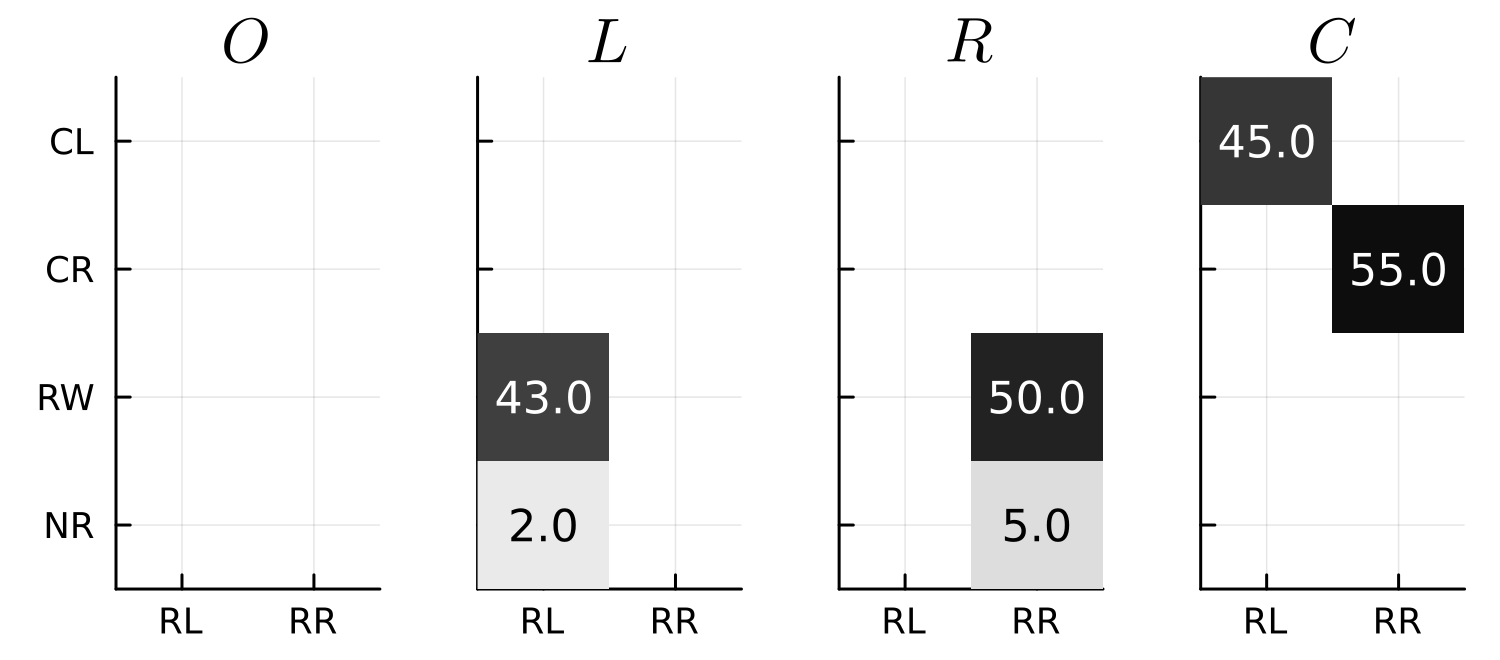

In [44]:
plotObservationStatistics(As[S], A_0)
savefig("figures/GFE_A")
plotObservationStatistics(As[S], A_0)

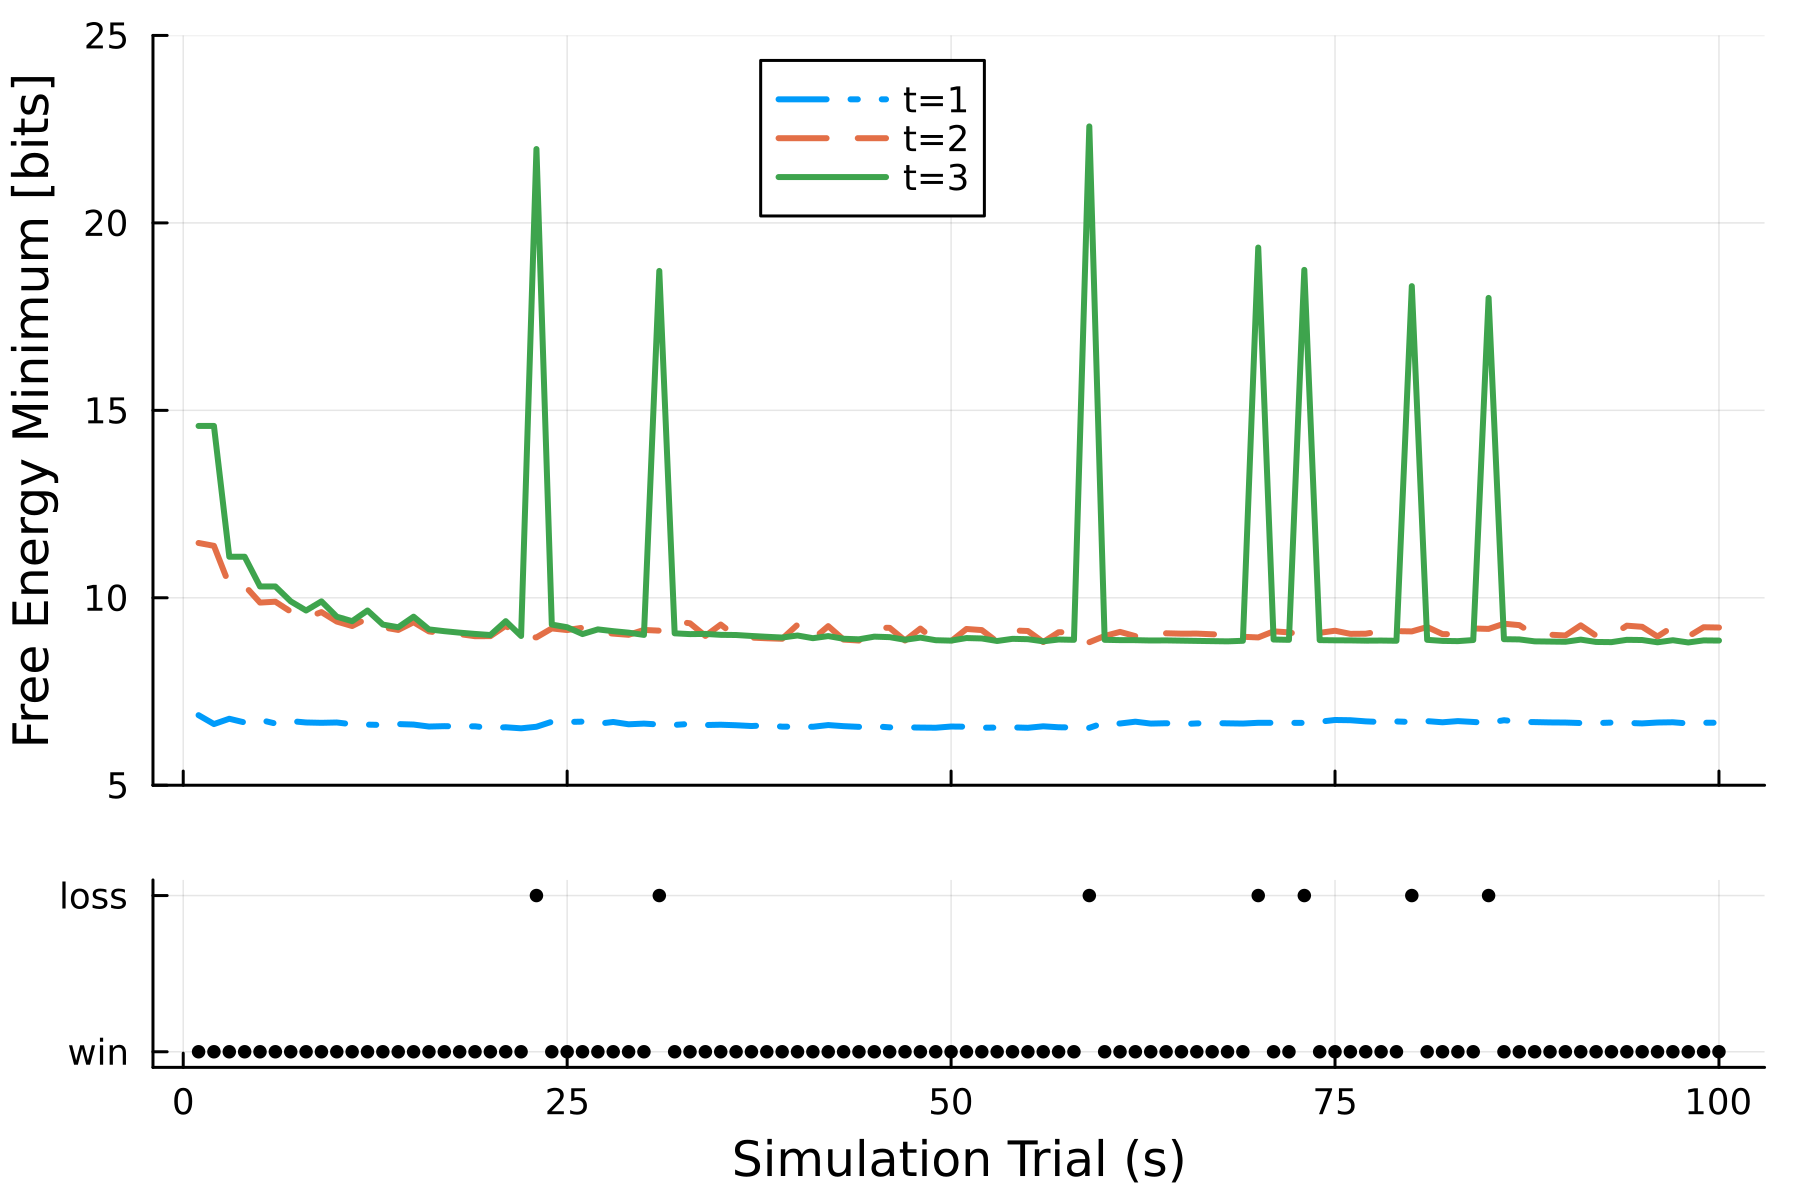

In [45]:
plotFreeEnergyMinimum(Gs, os, legend=100, ylim=(5,25))
savefig("figures/GFE_FE.png")
plotFreeEnergyMinimum(Gs, os, legend=100, ylim=(5,25))

In [26]:
using Random

function create_nk_landscape(N::Int, K::Int)
    if K >= N || K < 0
        error("K must be less than N and non-negative")
    end

    # Initialize the fitness contribution table
    fitness_table = Dict{Tuple{Int,Vector{Int}},Float64}()

    for i in 1:N
        # Generate all possible combinations of K+1 bits
        for combo in Iterators.product(fill([0, 1], K+1)...)
            fitness_table[(i, collect(combo))] = rand() * 100  # Multiply by 100
        end
    end

    # Function to calculate fitness of a given bit string
    function calculate_fitness(bitstring::Vector{Int})
        if length(bitstring) != N
            error("Bitstring length must be equal to N")
        end

        total_fitness = 0.0
        for i in 1:N
            # Get the K bits that influence this bit
            influencing_bits = [bitstring[mod1(i+j, N)] for j in 0:K]
            total_fitness += fitness_table[(i, influencing_bits)]
        end

        return total_fitness / N  # No need to multiply by 100 here
    end

    return calculate_fitness
end

create_nk_landscape (generic function with 1 method)

In [27]:
N = 10
K = 5
nk_landscape = create_nk_landscape(N, K)

# Generate a random bitstring
bitstring = rand(0:1, N)

# Calculate its fitness
fitness = nk_landscape(bitstring)
println("Fitness of $bitstring: $fitness")
println("nk_landscape = $(nk_landscape)")

Fitness of [0, 1, 0, 0, 1, 0, 1, 0, 1, 0]: 37.54239978070344
nk_landscape = calculate_fitness
